In [1]:
!pip install fastai==2.7.9
!pip install fastkaggle==0.0.7
!pip install fasterai==0.1.11
!pip install ipython-autotime==0.3.1
!pip install torch==1.12.1
%load_ext autotime

/bin/bash: /opt/conda/lib/libtinfo.so.6: no version information available (required by /bin/bash)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.0/47.0 kB 4.3 MB/s eta 0:00:00
  Attempting uninstall: pynvml
    Found existing installation: pynvml 11.5.0
    Uninstalling pynvml-11.5.0:
      Successfully uninstalled pynvml-11.5.0
/bin/bash: /opt/conda/lib/libtinfo.so.6: no version information available (required by /bin/bash)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 225.5/225.5 kB 8.9 MB/s eta 0:00:00
  Attempting uninstall: fastai
    Found existing installation: fastai 2.7.11
    Uninstalling fastai-2.7.11:
      Successfully uninstalled fastai-2.7.11
/bin/bash: /opt/conda/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /opt/conda/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /opt/conda/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /opt/conda/lib/libtinfo.so.6

In [4]:
from fastai.vision.all import *
from fastai.callback.all import *
from fastai.data.all import *
from fastai.imports import *
from fastai.torch_core import *
from fastai.learner import *
from fastai.fp16_utils import *

from fasterai.sparse.all import *
from fasterai.core.criteria import *
from fasterai.regularize.all import *

from fastkaggle import *

import torch
import torch.nn as nn
import torch.nn.functional as F


set_seed(42)

time: 10.3 s (started: 2023-04-20 03:28:44 +00:00)


In [7]:
@patch
def custom_plot_losses(self: Recorder, skip_start=5, with_valid=True, filename="temp.txt"):
    fig2 = plt.figure("Figure 2")

    idx = (np.array(self.iters)<skip_start).sum()
    train_col = self.metric_names.index('train_loss') - 1 
    plt.plot(self.iters[idx:], L(self.values[idx:]).itemgot(train_col), label='train loss')
    plt.legend()
    if with_valid:
        idx = (np.array(self.iters)<skip_start).sum()
        valid_col = self.metric_names.index('valid_loss') - 1 
        plt.plot(self.iters[idx:], L(self.values[idx:]).itemgot(valid_col), label='valid loss')
        plt.legend()

    
@patch
def custom_plot_values(self: Recorder, skip_start=5, with_valid=True):
    fig3 = plt.figure("Figure 3")
    
    idx = (np.array(self.iters)<skip_start).sum()
    train_col = self.metric_names.index('train_accuracy') - 1 
    plt.plot(self.iters[idx:], L(self.values[idx:]).itemgot(train_col), label='train accuracy')

    plt.legend()
    if with_valid:
        idx = (np.array(self.iters)<skip_start).sum()
        valid_col = self.metric_names.index('valid_accuracy') - 1 
        plt.plot(self.iters[idx:], L(self.values[idx:]).itemgot(valid_col), label='valid accuracy')
        plt.legend()


time: 4.43 ms (started: 2023-04-20 03:28:54 +00:00)


In [8]:
comp = 'paddy-diseases/paddy-diseases'

path = setup_comp(comp, install='"fastcore>=1.4.5" "fastai>=2.7.1" "timm>=0.6.2.dev0"')

time: 10.7 s (started: 2023-04-20 03:28:54 +00:00)


In [9]:
dls = ImageDataLoaders.from_folder(path/"train", 
                                   valid_pct=0.25, 
                                   item_tfms=Resize(256), 
                                   batch_tfms=aug_transforms(   size=64, 
                                                                min_scale=0.75,
                                                                max_rotate=10., 
                                                                min_zoom=0.8, 
                                                                max_zoom=1.2, 
                                                            
                                                            ), 
                                   bs=32//2)

time: 10 s (started: 2023-04-20 03:29:05 +00:00)


In [10]:
sp_cb=[
      GradientAccumulation(32), 
#       SparsifyCallback(sparsity=25, 
#                          granularity='filter', 
#                          context='local', 
#                          criteria=large_final, 
#                          schedule=one_cycle),


]

time: 567 µs (started: 2023-04-20 03:29:15 +00:00)


In [11]:
model = vgg16_bn(num_classes=10)


time: 2.05 s (started: 2023-04-20 03:29:15 +00:00)


In [12]:
learn = Learner(dls, 
                model, 
                metrics=[accuracy,
                         error_rate,
                        ]).to_non_native_fp16()
learn.unfreeze()
learn.recorder.train_metrics = True
learn.path = Path("/kaggle/working/")

time: 11.3 ms (started: 2023-04-20 03:29:17 +00:00)


epoch,train_loss,train_accuracy,train_error_rate,valid_loss,valid_accuracy,valid_error_rate,time
0,2.237047,0.173077,0.826923,2.073943,0.258173,0.741827,01:30
1,2.121841,0.222596,0.777404,2.028729,0.280769,0.719231,01:20
2,2.124861,0.242628,0.757372,1.985823,0.302885,0.697115,01:22
3,2.060550,0.263942,0.736058,1.960941,0.297596,0.702404,01:22
4,2.042643,0.279647,0.720353,1.896004,0.339904,0.660096,01:22
5,1.995021,0.285417,0.714583,1.864247,0.361538,0.638462,01:49
6,1.918332,0.319872,0.680128,1.796375,0.402404,0.597596,02:11
7,1.892985,0.325801,0.674199,1.720312,0.398558,0.601442,02:09
8,1.847489,0.355769,0.644231,1.693864,0.430288,0.569712,01:34
9,1.828682,0.364744,0.635256,1.626429,0.438942,0.561058,01:20


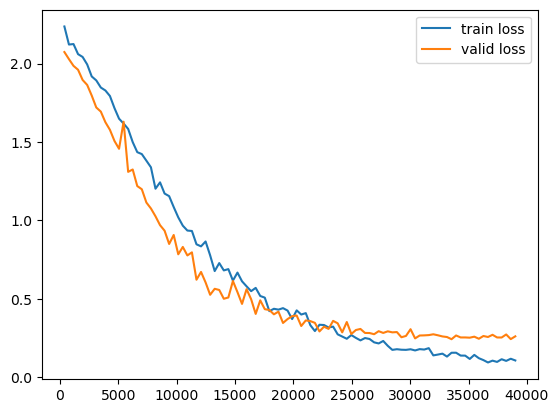

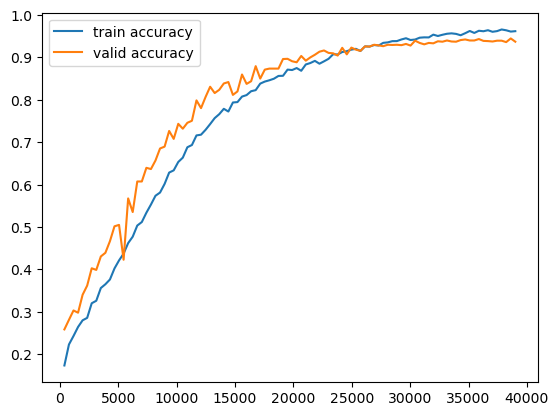

time: 2h 17min 47s (started: 2023-04-20 03:29:21 +00:00)


In [17]:
learn.fit_one_cycle(100, 3e-5, cbs=sp_cb)
                    
learn.recorder.custom_plot_losses()
learn.recorder.custom_plot_values()


In [29]:
learn.export(Path("/kaggle/working/VGG16_bn_non_native_fp16_accum2.pkl"))

time: 1.82 s (started: 2023-04-20 05:47:08 +00:00)
